In [1]:
import os.path
import tensorflow as tf
import keras
import nltk
from nltk import word_tokenize
from nltk.tokenize.moses import MosesTokenizer
from nltk.tokenize.moses import MosesDetokenizer
import pandas as pd
import numpy as np
import re
import codecs
import sys
import operator
import matplotlib.pyplot as plt

# sys.path.insert(0, '/Users/tengi/insight-project/lib/pwkp_dataset_parser')
# from pwkp_parser import parse_pwkp_file
# download the princeton wordnet, once run it once
# nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
%matplotlib inline
#nltk.download('all')

/home/paperspace/anaconda3/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
pwkp_source_file = 'data/PWKP/PWKP_108016'

translations = []

# generate complex-simple paris in translations

def retrieve_complex_simplex_translations(src_file):
    total_simple_sentences = 0;
    with open(pwkp_source_file) as pwkp_file:
            translation_beginning = True
            translation = None
            for line in pwkp_file:
                
                
                if translation_beginning:
                    translation = (line.strip(), "")
                    translation_beginning = False
                else:
                    if line == "\n":
                        translation_beginning = True
                        translations.append(translation)
                    else:
                        total_simple_sentences += 1;
                        source, target = translation
                        translation =\
                            (source, target + line.strip() + " ")
    return (translations, total_simple_sentences);

In [3]:
# get complex-simple pairs
translations, total_simple_sentences = retrieve_complex_simplex_translations(pwkp_source_file)

In [4]:
#tokenize the original data file (PWKP_108016) by Moses
tokenizer = MosesTokenizer()
np.random.shuffle(translations)

complex_sentences = [pair[0] for pair in translations]
simple_sentences = [pair[1] for pair in translations]

complex_sentences_tok = [tokenizer.tokenize(sent, return_str = True) for sent in complex_sentences]
simple_sentences_tok = [tokenizer.tokenize(sent, return_str = True) for sent in simple_sentences] 


In [11]:
complex_tok_words = [word for sent in complex_sentences for word in tokenizer.tokenize(sent)]
simple_tok_words = [word for sent in simple_sentences for word in tokenizer.tokenize(sent)]

In [18]:
fdist = nltk.FreqDist(complex_tok_words+simple_tok_words)

In [19]:
print(fdist.B())
print(fdist.N())

121793
4825466


In [6]:
corpus_file = 'data/PWKP/PWKP_108016.tok'

complex_sentences_file = 'data/PWKP/complex.tok'
simple_sentences_file = 'data/PWKP/simple.tok'

complex_train_file = 'data/PWKP/train.tok.complex'
simple_train_file = 'data/PWKP/train.tok.simple'

complex_val_file = 'data/PWKP/val.tok.complex'
simple_val_file = 'data/PWKP/val.tok.simple'

complex_test_file = 'data/PWKP/test.tok.complex'
simple_test_file = 'data/PWKP/test.tok.simple'

val_size = 300
test_size = 300

with open(corpus_file, 'w') as f:
    for i in range(len(complex_sentences_tok)):
        f.write(complex_sentences_tok[i] + '\n')
        f.write(simple_sentences_tok[i] + '\n\n')
        
        
with open(complex_sentences_file, 'w') as f:
    for sent in complex_sentences_tok:
        f.write(sent + '\n')
        
with open(simple_sentences_file, 'w') as f:
    for sent in simple_sentences_tok:
        f.write(sent + '\n')
 
with open(complex_train_file, 'w') as f:
    for sent in complex_sentences_tok[:-(val_size+test_size)]:
        f.write(sent + '\n')
        
with open(simple_train_file, 'w') as f:
    for sent in simple_sentences_tok[:-(val_size+test_size)]:
        f.write(sent + '\n')
        
with open(complex_val_file, 'w') as f:
    for sent in complex_sentences_tok[-(val_size+test_size):-test_size]:
        f.write(sent + '\n')
        
with open(simple_val_file, 'w') as f:
    for sent in simple_sentences_tok[-(val_size+test_size):-test_size]:
        f.write(sent + '\n')
        
with open(complex_test_file, 'w') as f:
    for sent in complex_sentences_tok[-test_size:]:
        f.write(sent + '\n')
        
with open(simple_test_file, 'w') as f:
    for sent in simple_sentences_tok[-test_size:]:
        f.write(sent + '\n')
        
    

In [10]:
# Learn a vocabulary using 10,000 merge operations
!./subword-nmt/learn_bpe.py -s 10000 < data/PWKP/PWKP_108016.tok > data/PWKP/codes.bpe

# Apply the vocabulary to the training file
!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/PWKP_108016.tok > data/PWKP/PWKP_108016.tok.bpe
!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/complex.tok > data/PWKP/complex.tok.bpe
!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/simple.tok > data/PWKP/simple.tok.bpe

!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/train.tok.complex > data/PWKP/train.tok.bpe.complex

!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/train.tok.simple > data/PWKP/train.tok.bpe.simple

!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/val.tok.complex > data/PWKP/val.tok.bpe.complex

!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/val.tok.simple > data/PWKP/val.tok.bpe.simple

!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/test.tok.complex > data/PWKP/test.tok.bpe.complex

!./subword-nmt/apply_bpe.py -c data/PWKP/codes.bpe < data/PWKP/test.tok.simple > data/PWKP/test.tok.bpe.simple

In [22]:
!cat data/PWKP/PWKP_108016.tok.bpe | ./subword-nmt/get_vocab.py > data/PWKP/PWKP_108016.vocab.tok.bpe
!cat data/PWKP/complex.tok.bpe | ./subword-nmt/get_vocab.py > data/PWKP/vocab.tok.bpe.complex
!cat data/PWKP/simple.tok.bpe | ./subword-nmt/get_vocab.py > data/PWKP/vocab.tok.bpe.simple

In [2]:
detokenizer = MosesDetokenizer()
detokenizer.detokenize("a b , cd .", return_str = True)

'a b, c d.'

In [8]:
# check for identical sentence pairs
identical_pairs = 0
for pair in translations:
    if pair[0] == pair[1]:
        identical_pairs+1
print("Identical Pairs: %d"%(identical_pairs))

total_complex_sentences = len(translations)
total_complex_words = 0
total_simple_words = 0

complex_dict = {}
simple_dict = {}

lmtzr = WordNetLemmatizer()

#regular expression to capture words
#capture: words word's
#not capture: words'
rgx = re.compile("(\w[\w']*\w|\w)")
for i in range(total_complex_sentences):
    complex_sentence = translations[i][0]
    simple_sentence = translations[i][1]

    complex_words = rgx.findall(complex_sentence)
    simple_words = rgx.findall(simple_sentence)
    
    for w in complex_words:
        #wordnet lemmatize 'has' to ha, 'was' to wa, just use original word for the time
        #w_lem = lmtzr.lemmatize(w)
        complex_dict[w] = complex_dict.get(w, 0)+1
        
    for w in simple_words:
        #w_lem = lmtzr.lemmatize(w)
        simple_dict[w] = simple_dict.get(w, 0)+1
    
    total_complex_words += len(complex_words)
    total_simple_words += len(simple_words)

complex_freq_count = list(complex_dict.values())
simple_freq_count = list(simple_dict.values())

complex_words_in_dict = sum(complex_freq_count)
simple_words_in_dict = sum(simple_freq_count)

avg_chars_per_word_complex = sum([len(w)*complex_dict[w] for w in complex_dict]) / float(complex_words_in_dict)
avg_chars_per_word_simple = sum([len(w)*simple_dict[w] for w in simple_dict]) / float(simple_words_in_dict)

df = pd.DataFrame({'name': ['complex', 'simple'],
                   '#words/sentence': [total_complex_words/float(total_complex_sentences), total_simple_words/float(total_simple_sentences)],
                   '#chars/word': [avg_chars_per_word_complex, avg_chars_per_word_simple],
                   'vocab': [len(complex_dict), len(simple_dict)]})
df.set_index('name')

Identical Pairs: 0


,#chars/word,#words/sentence,vocab
name,,,
complex,4.864884,21.537356,104840
simple,4.716778,16.584285,87589


In [9]:
vocab_name_complex = 'data/PWKP/vocab.complex'
vocab_name_simple = 'data/PWKP/vocab.simple'

sorted_complex_tuple = sorted(complex_dict.items(), key=operator.itemgetter(1), reverse = True)
sorted_simple_tuple = sorted(simple_dict.items(), key=operator.itemgetter(1), reverse = True)

K = 20;
print('%d most frequency words (frequency):'%K)
print("           %s            %s         \n"%('complex', 'simple'))
for i in range(K):
    print('%10s (%.2f%%)%10s (%.2f%%)'%(sorted_complex_tuple[i][0],
                                  sorted_complex_tuple[i][1]*100/float(complex_words_in_dict),
                                  sorted_simple_tuple[i][0],
                                  sorted_simple_tuple[i][1]*100/float(simple_words_in_dict)))

20 most frequency words (frequency):
           complex            simple         

       the (6.35%)       the (6.34%)
        of (3.85%)        of (3.69%)
        in (2.95%)        in (3.05%)
       and (2.91%)       and (2.58%)
         a (2.23%)        is (2.12%)
        is (1.77%)         a (2.11%)
        to (1.68%)        to (1.57%)
       The (1.09%)       The (1.26%)
       was (1.03%)       was (1.20%)
        as (0.81%)        by (0.67%)
        by (0.73%)        on (0.65%)
        on (0.69%)        It (0.63%)
       for (0.65%)       for (0.63%)
      with (0.56%)        as (0.63%)
      from (0.48%)       are (0.50%)
      that (0.43%)      with (0.49%)
        an (0.42%)      from (0.47%)
       are (0.41%)      that (0.46%)
        or (0.40%)        an (0.40%)
        at (0.39%)        In (0.38%)


In [10]:
complex_words_sorted = [item[0] for item in sorted_complex_tuple]
complex_count_sorted = [item[1] for item in sorted_complex_tuple]

simple_words_sorted = [item[0] for item in sorted_simple_tuple]
simple_count_sorted = [item[1] for item in sorted_simple_tuple]


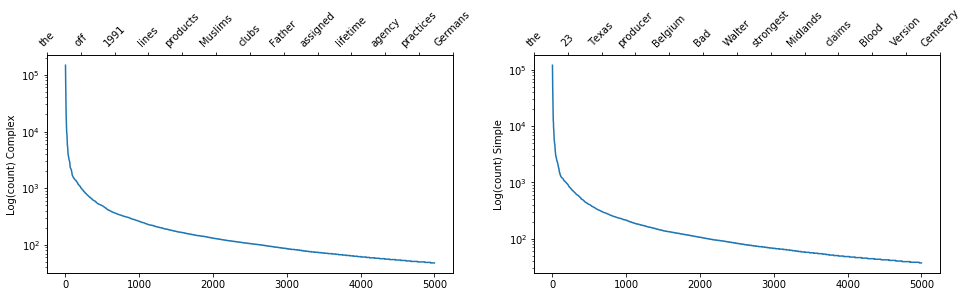

In [11]:
plt.figure(figsize=(16, 4))
N = 5000
subIndex = range(0, N, 400)

axe = plt.subplot(1,2,1)
h1 = plt.plot(range(N), np.array(complex_count_sorted[:5000]))
plt.ylabel('Log(count) Complex')
axe1 = axe.twiny()
plt.xticks(subIndex, np.array(complex_words_sorted)[subIndex], rotation = 45)
plt.yscale('log')
axe = plt.subplot(1,2,2)
h2 = plt.plot(simple_count_sorted[:5000])
plt.ylabel('Log(count) Simple')
axe1 = axe.twiny()
plt.xticks(subIndex, np.array(simple_words_sorted)[subIndex], rotation = 45)
plt.yscale('log')

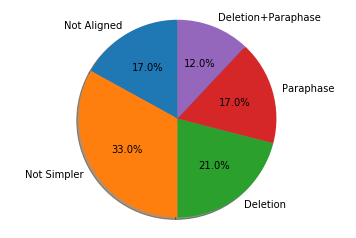

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Not Aligned', 'Not Simpler', 'Deletion', 'Paraphase', 'Deletion+Paraphase'
sizes = [17, 33, 21, 17, 12]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [44]:
text_file = open(r'./data/PWKP/PWKP_108016.tok.bpe',"r")
p = text_file.read()
words = word_tokenize(p)
fdist = nltk.FreqDist(words)
print(fdist)

<FreqDist with 8023 samples and 10434119 outcomes>


In [24]:
"a b c\n".strip()

'a b c'